<a href="https://colab.research.google.com/github/Anagha235/CNN-Data-Science-Project/blob/main/BaslineCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras import Input

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32

)

Found 4752 files belonging to 9 classes.


In [5]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [6]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label


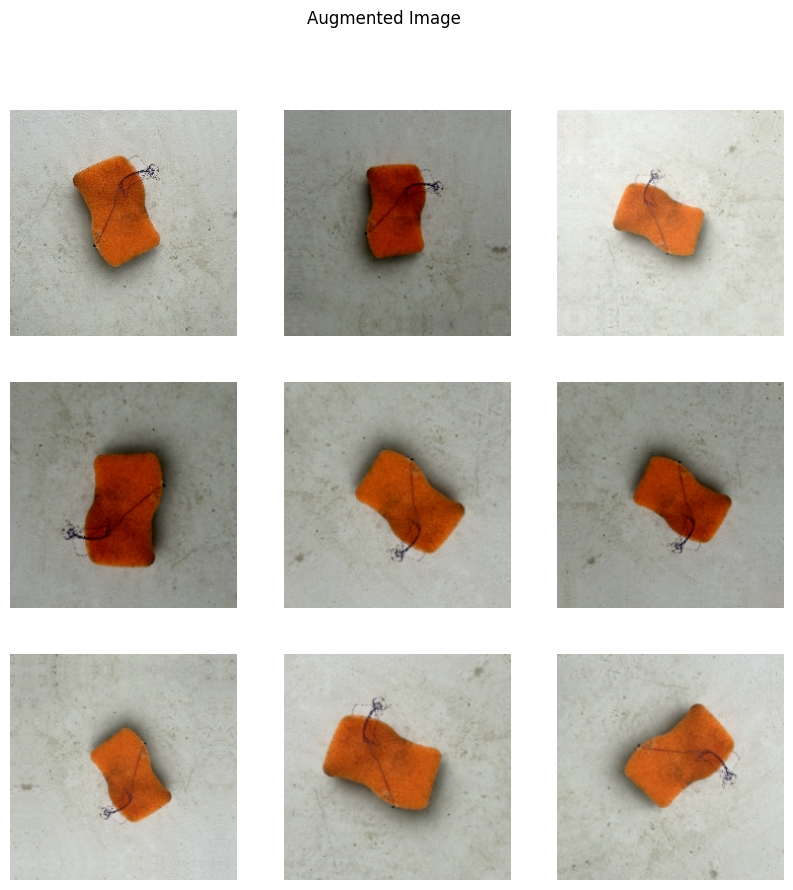

In [7]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle('Augmented Image')
    plt.show()


visualize_dataset(dataset, class_names)

In [8]:

def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [9]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [10]:

# 1. Shuffle once with seed BEFORE splitting
shuffled_dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

# 2. Split sizes
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

# 3. Perform split
train_dataset = shuffled_dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)


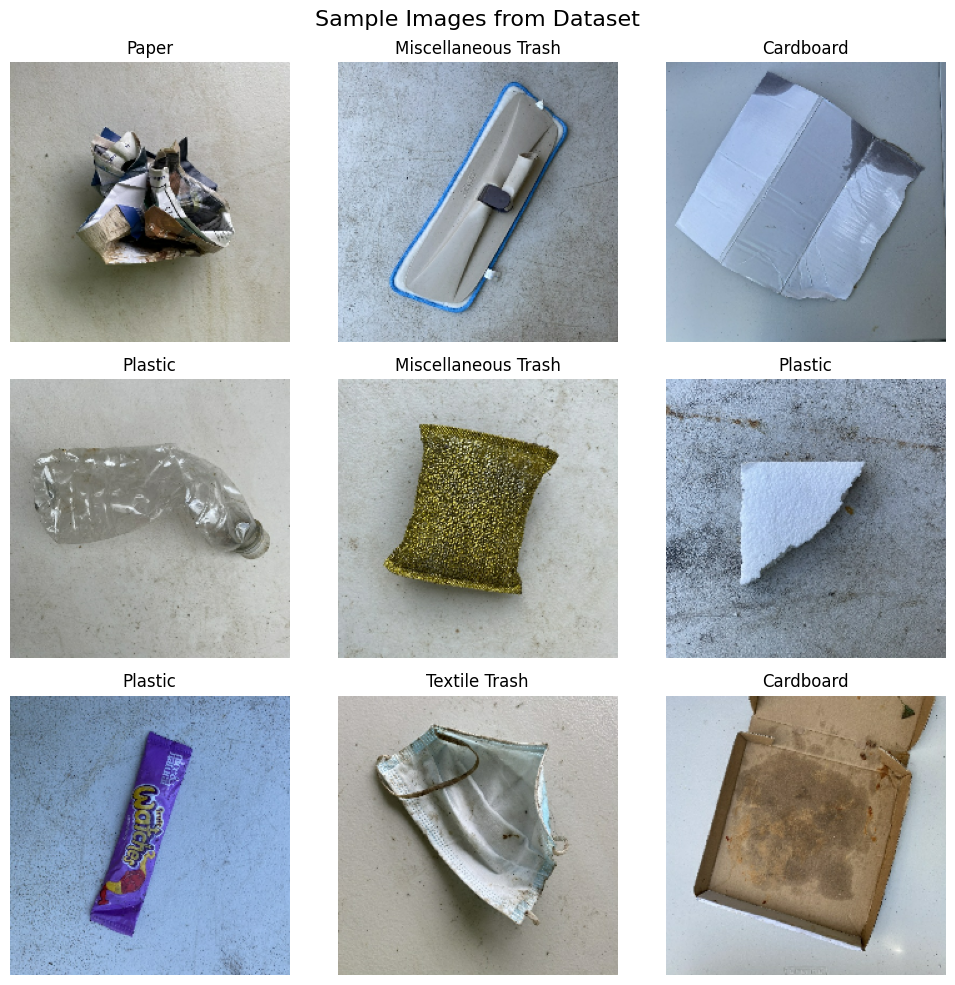

In [ ]:


plt.figure(figsize=(10, 10))

    # Take 1 batch
for images, labels in dataset.take(1):
  for i in range(9):
    image = images[i]         # Extract one image from the batch
    label_idx = labels[i].numpy()  # Get class index

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))  # Convert to displayable format
    plt.title(class_names[label_idx])
    plt.axis("off")

plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()



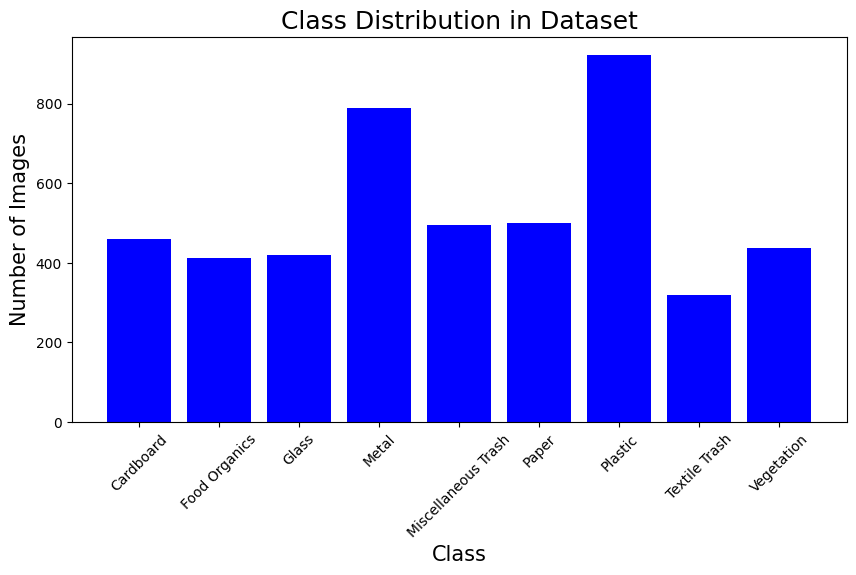

In [11]:

class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [12]:
label_extraction_ds = dataset.shuffle(buffer_size=dataset_size, seed=42).take(train_size)
label_extraction_ds = label_extraction_ds.unbatch().batch(256)

train_labels = []

for batch in label_extraction_ds:
    _, labels = batch

    if tf.rank(labels).numpy() > 1:
        labels = tf.argmax(labels, axis=1)

    train_labels.extend(labels.numpy())

train_labels = np.array(train_labels)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights_dict)




Class weights: {0: np.float64(1.1219512195121952), 1: np.float64(1.2432432432432432), 2: np.float64(1.3049645390070923), 3: np.float64(0.6606822262118492), 4: np.float64(1.0), 5: np.float64(1.1323076923076922), 6: np.float64(0.5670261941448382), 7: np.float64(1.7777777777777777), 8: np.float64(1.2266666666666666)}


In [13]:

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for multi-class classification with one-hot labels.
    """
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

    return loss

In [14]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:

        return float(lr * tf.math.exp(-0.1))
lr_scheduler = LearningRateScheduler(scheduler)

In [15]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:

model = models.Sequential([
    Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
    ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=categorical_focal_loss(),
                  metrics=['accuracy'])




In [ ]:
history = model.fit(train_dataset, epochs=35, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[lr_scheduler])

Epoch 1/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 114s 631ms/step - accuracy: 0.1181 - loss: 0.4385 - val_accuracy: 0.2756 - val_loss: 0.3767 - learning_rate: 1.0000e-04
Epoch 2/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 84s 627ms/step - accuracy: 0.2268 - loss: 0.3875 - val_accuracy: 0.3023 - val_loss: 0.3889 - learning_rate: 1.0000e-04
Epoch 3/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 86s 625ms/step - accuracy: 0.2886 - loss: 0.3487 - val_accuracy: 0.3665 - val_loss: 0.3425 - learning_rate: 1.0000e-04
Epoch 4/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 161s 821ms/step - accuracy: 0.2888 - loss: 0.3323 - val_accuracy: 0.3821 - val_loss: 0.3402 - learning_rate: 1.0000e-04
Epoch 5/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 85s 622ms/step - accuracy: 0.3304 - loss: 0.3129 - val_accuracy: 0.4688 - val_loss: 0.2926 - learning_rate: 1.0000e-04
Epoch 6/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 105s 826ms/step - accuracy: 0.3593 - loss: 0.3080 - val_accuracy: 0.3920 - val_loss: 0.3315 - learning_rate: 9.0484e-05
Epoch 7/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 122

In [ ]:
model.save("my_model.keras")


In [ ]:
y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [ ]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.65      0.70      0.67        66
           1       0.40      0.76      0.53        71
           2       0.93      0.54      0.68        69
           3       0.49      0.50      0.49       111
           4       0.30      0.28      0.29        79
           5       0.48      0.58      0.52        67
           6       0.63      0.28      0.39       147
           7       0.53      0.21      0.30        48
           8       0.41      0.96      0.58        46

    accuracy                           0.49       704
   macro avg       0.53      0.53      0.49       704
weighted avg       0.54      0.49      0.48       704



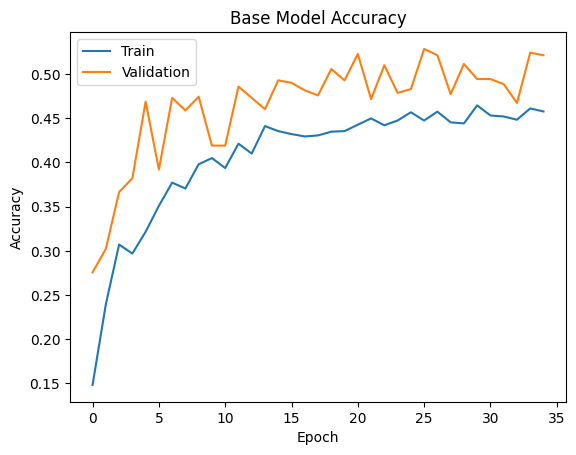

In [ ]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

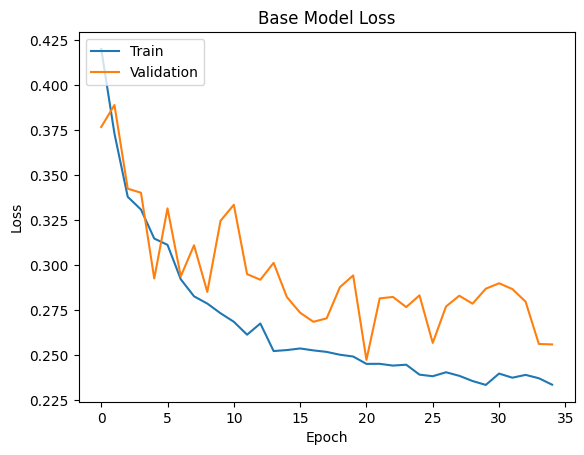

In [ ]:
def plot_hist(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

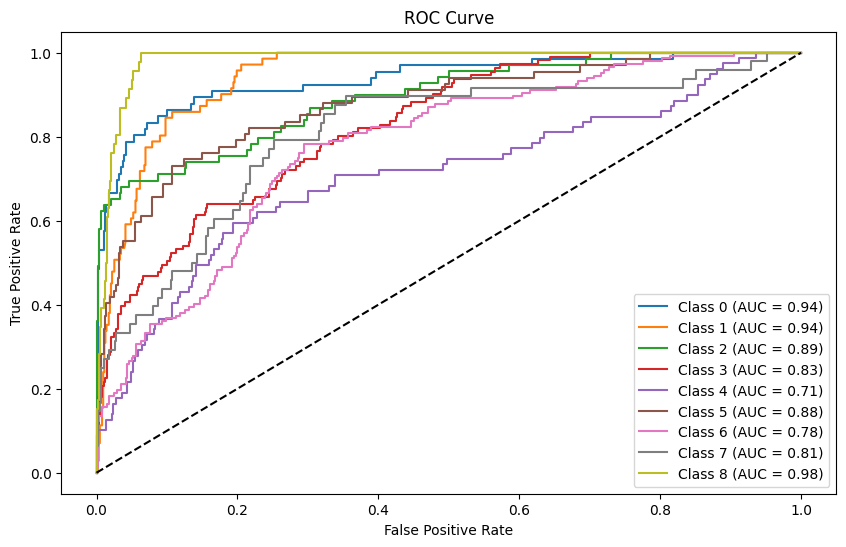

In [ ]:

num_classes = 9
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

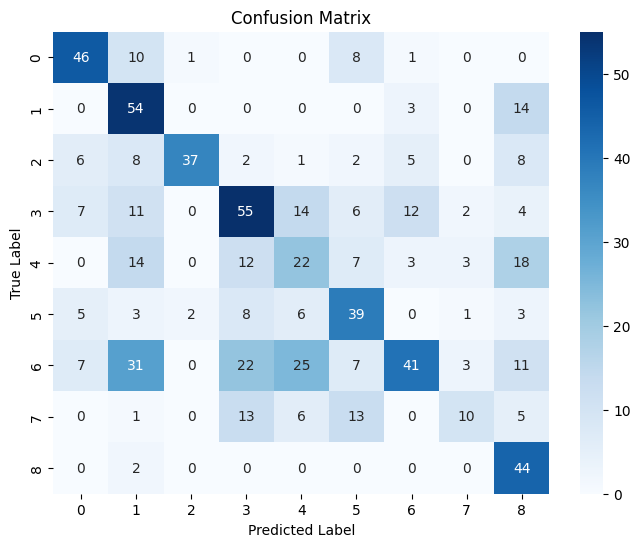

In [ ]:

cm = confusion_matrix(y_true_base, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:

test_loss_base, test_acc_base = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.5170 - loss: 0.2526
Test Accuracy: 0.5177
Test Loss: 0.2548


In [16]:
import keras_tuner as kt
from tensorflow.keras import layers, models

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(224, 224, 3)))
    model.add(layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu'
    ))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=3,
        activation='relu'
    ))
    model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int("units", min_value=64, max_value=512, step=64)))
    model.add(layers.Dropout(hp.Float('dropout', 0.3, 0.7, step=0.1)))
    model.add(layers.Dense(9, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [17]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_tuning',
    project_name='cnn_baseline'
)

tuner.search(train_dataset, validation_data=val_dataset, epochs=10)


Trial 5 Complete [00h 09m 41s]
val_accuracy: 0.21590909361839294

Best val_accuracy So Far: 0.5497159361839294
Total elapsed time: 00h 48m 18s


In [18]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [33]:
history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[lr_scheduler,reduce_lr]
)


Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 55s 454ms/step - accuracy: 0.6227 - loss: 1.0451 - val_accuracy: 0.5930 - val_loss: 1.2466 - learning_rate: 1.3946e-06
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - accuracy: 0.6158 - loss: 1.0475 - val_accuracy: 0.6264 - val_loss: 1.1664 - learning_rate: 1.3946e-06
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - accuracy: 0.6320 - loss: 1.0589 - val_accuracy: 0.5909 - val_loss: 1.2527 - learning_rate: 1.3946e-06
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 54s 452ms/step - accuracy: 0.6222 - loss: 1.0627 - val_accuracy: 0.6335 - val_loss: 1.2070 - learning_rate: 1.3946e-06
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.6149 - loss: 1.0451
Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-06.
104/104 ━━━━━━━━━━━━━━━━━━━━ 54s 452ms/step - accuracy: 0.6149 - loss: 1.0451 - val_accuracy: 0.5980 - val_loss: 1.2060 - learning_rate: 1.3946e-06
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - accuracy: 0

In [41]:
best_model.save("my_model.keras")

In [44]:
y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [45]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68        75
           1       0.63      0.72      0.67        64
           2       0.88      0.63      0.74        60
           3       0.77      0.60      0.68       116
           4       0.39      0.26      0.31        70
           5       0.63      0.52      0.57        71
           6       0.55      0.85      0.67       134
           7       1.00      0.09      0.16        47
           8       0.63      1.00      0.77        67

    accuracy                           0.63       704
   macro avg       0.68      0.59      0.58       704
weighted avg       0.67      0.63      0.61       704



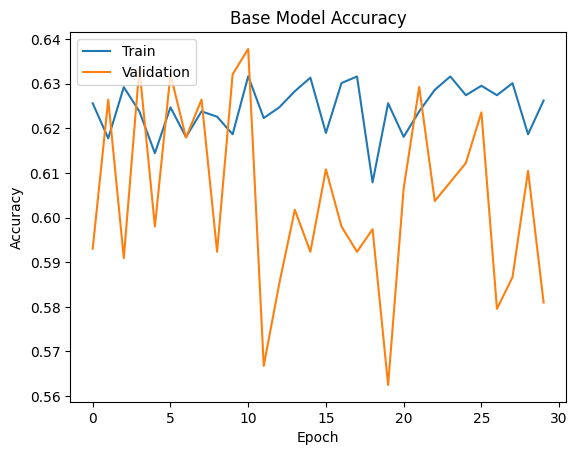

In [46]:
def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

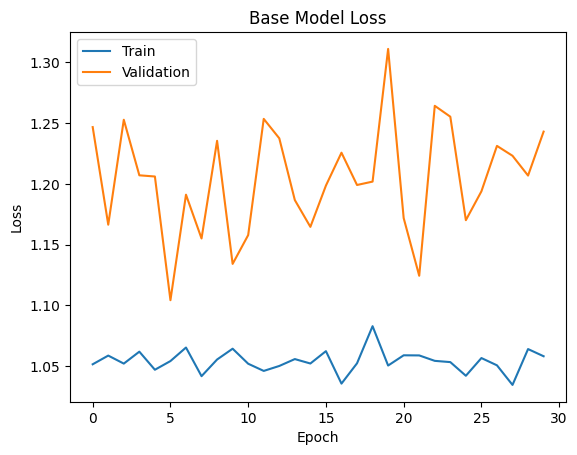

In [47]:
def plot_hist(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history)

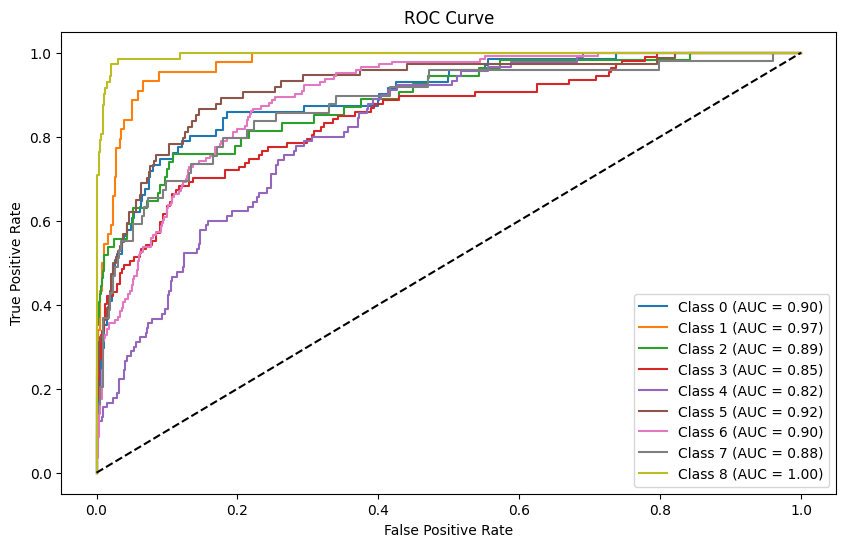

In [39]:

num_classes = 9
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

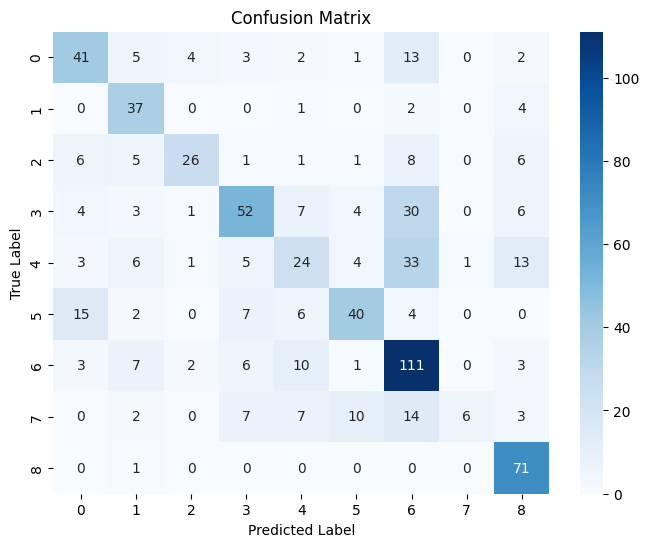

In [40]:

cm = confusion_matrix(y_true_base, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()